
Import the necessary modules

In [557]:
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import contextlib
import itertools
import utils
import time
import sys
import io

from tqdm import tqdm
from heapq import heappop, heappush
from utils import pretty_print_timetable
from check_constraints import check_mandatory_constraints

In [558]:
class Day:
    def __init__(self, name):
        self.name = name

In [559]:
class Interval:
    def __init__(self, interval):
        self.interval = interval

In [560]:
class Subject:
    def __init__(self, name, capacity, occupied=0):
        self.name = name
        self.capacity = capacity
        self.occupied = occupied
    
    def is_covered(self):
        return self.occupied >= self.capacity

    def update(self, lecture_hall):
        self.occupied += lecture_hall.capacity

    def restart(self):
        self.occupied = 0

In [561]:
class Constraints:
    def __init__(self, constraints):
        days = ["Luni", "Marti", "Miercuri", "Joi", "Vineri", "Sambata", "Duminica"]
        self.prefferable_days = []
        self.prefferable_intervals = []
        self.c_pauses = []
        
        for c in constraints:
            if c in days:
                self.prefferable_days.append(c)
            
            if "-" in c and not "!" in c:
                self.prefferable_intervals.append(c)

            if "Pauza" in c:
                self.c_pauses.append(c)

In [562]:
class Teacher:
    def __init__(self, name, constraints, subjects, num_intervals=0):
        self.name = name
        self.num_intervals = num_intervals
        self.constraints = Constraints(constraints)
        self.subjects = subjects

    def is_available(self):
        return self.num_intervals < 7

    def is_specialized(self, s):
        """
            Tells if the teacher may teach the subject s received as a parameter
        """
        return s in self.subjects

    def matches_teacher_copy(self, other):
        return self.name == other.name

    def update(self):
        self.num_intervals += 1

    def restart(self):
        self.num_intervals = 0

    def matches_requirements(self, searched_slot, slots):
        return not any(slot.teacher == self for slot in [s for s in slots if s.interval == searched_slot.interval and s.day == searched_slot.day])


In [563]:
class LectureHall:
    def __init__(self, name, capacity, subjects):
        self.name = name
        self.capacity = capacity
        self.subjects = subjects

In [756]:
class Slot:
    def __init__(self, day, interval, lecture_hall):
        self.day = day
        self.interval = interval
        self.lecture_hall = lecture_hall

        self.teacher = None
        self.subject = None

    def is_available(self):
        return (self.subject is None) or (self.teacher is None)

    def matches_requirements(self, lecture_hall, slots, teacher = None):
        return self.lecture_hall.name == lecture_hall.name and (teacher is None or\
            not any(slot.teacher == teacher for slot in [s for s in slots if s.interval == self.interval and s.day == self.day]))

    def matches_subject(self, subject: str):
        return subject in [s.name for s in lecture_hall.subjects]

    def matches_slot_copy(self, other):
        return self.day.name == other.day.name and self.interval.interval == other.interval.interval and self.lecture_hall.name == other.lecture_hall.name

    def matches_slot_assignments(self, other):
        if self.is_available() and other.is_available():
            return True
        return not((not self.is_available() and other.is_available()) or\
            (self.is_available() and not other.is_available()) or\
            (not self.teacher.name == other.teacher.name or not self.subject.name == other.subject.name)) 

    def update(self, subject, teacher):
        self.subject = subject
        self.teacher = teacher

    def restart(self):
        self.subject = None
        self.teacher = None

    def swap(self, other):
        self.subject, other.subject = other.subject, self.subject
        self.teacher, other.teacher = other.teacher, self.teacher                

    def get_same_interval_slots(slot, day, interval, timetable):
        return [s for s in timetable["timetable"].slots\
                if s.day == day and s.interval == interval and s != slot]

    def can_swap(self, other, timetable):
        def can_swap_helper(s1, s2, timetable):
            # Check subject permissions
            subject_permissions = s1.subject_permissions(s2) and s2.subject_permissions(s1)

            if not subject_permissions:
                return False

            # Take all the slots from the same day and intervals
            same_interval_slots = Slot.get_same_interval_slots(s1, s1.day, s1.interval, timetable)

            # Check if the s2 teacher has another class
            teacher_cond = not any(s2.teacher == s.teacher for s in same_interval_slots)

            # Check if the s2 lecture hall is used in that interval
            lecture_hall_cond = not any(not s.is_available() and s2.lecture_hall == s.lecture_hall for s in same_interval_slots)

            return teacher_cond and lecture_hall_cond
        
        return can_swap_helper(self, other, timetable) and can_swap_helper(other, self, timetable)

    def move(self, day, interval, slot):
        slot_to_move = slot
        slot_to_move.teacher = self.teacher
        slot_to_move.subject = self.subject

        self.teacher = None
        self.subject = None
    
    def can_move(self, day, interval, timetable):
        same_interval_slots = Slot.get_same_interval_slots(self, day, interval, timetable)
        return not any(s.teacher == self.teacher for s in same_interval_slots) and\
            not any(not s.is_available() and s.lecture_hall == self.lecture_hall for s in same_interval_slots)

    def assign_new_teacher(self, teacher):
        old_teacher = self.teacher
        old_teacher.num_intervals -= 1
        self.teacher = teacher
        teacher.update()

    def can_assign_new_teacher(self, teacher, timetable):
        if teacher is self.teacher:
            return False

        if not teacher.is_available():
            return False
        
        same_interval_slots = Slot.get_same_interval_slots(self, self.day, self.interval, timetable)
        
        return not any(s.teacher == teacher for s in same_interval_slots) and teacher.is_specialized(self.subject)

    def subject_permissions(self, other):
        if self.subject is None:
            return True
    
        if self.subject.name not in [s.name for s in other.lecture_hall.subjects]:
            return False
        
        if self.lecture_hall.capacity != other.lecture_hall.capacity:
            return False
        return True


In [565]:
class Timetable:
    def __init__(self, days=[], interval=[], lecture_halls=[]):
        self.slots = []
        for d in days:
            for i in interval:
                for l in lecture_halls:
                    self.slots.append(Slot(d, i, l))

In [566]:
def process_data(data):
    # Initialize Days and Intervals
    days = [Day(day_name) for day_name in data["Zile"]]
    intervals = [Interval(interval) for interval in data["Intervale"]]

    # Initialize subjects
    subjects = [Subject(name, capacity) for name, capacity in data["Materii"].items()]
    
    # Initialize lecture halls
    lecture_halls = [LectureHall(name, details["Capacitate"], [s for s in subjects if s.name in details["Materii"]]) for name, details in data["Sali"].items()]

    # Create empty timetable
    timetable = Timetable(days, intervals, lecture_halls)

    # Initialize teachers
    teachers = [Teacher(name, details["Constrangeri"], [s for s in subjects if s.name in details["Materii"]]) for name, details in data["Profesori"].items()]
    
    return {
        "timetable": timetable,
        "days": days,
        "intervals": intervals,
        "subjects": subjects,
        "lecture_halls": lecture_halls,
        "teachers": teachers
    }

In [748]:
def print_data(data):
    print("Timetable Slots:")
    for slot in data["timetable"].slots:
        slot_details = f"{slot.day.name} {slot.interval.interval}, Subject: {slot.subject.name if slot.subject else 'None'}, "
        slot_details += f"Teacher: {slot.teacher.name if slot.teacher else 'None'}, "
        slot_details += f"Hall: {slot.lecture_hall.name if slot.lecture_hall else 'None'}"
        print(slot_details)

    print("\nSubjects:")
    for subject in data["subjects"]:
        print(f"{subject.name}, Capacity: {subject.capacity}, Occupied: {subject.occupied}")

    print("\nLecture Halls:")
    for hall in data["lecture_halls"]:
        subjects = ', '.join([s.name for s in hall.subjects])
        print(f"{hall.name}, Capacity: {hall.capacity}, Subjects: {subjects}")

    print("\nTeachers:")
    for teacher in data["teachers"]:
        subjects = ', '.join([s.name for s in teacher.subjects])
        constraints = f"Days: {', '.join(teacher.constraints.prefferable_days)}, Intervals: {', '.join(teacher.constraints.prefferable_intervals)}, Pauses: {', '.join(teacher.constraints.c_pauses)}"
        print(f"{teacher.name}, Subjects: {subjects}, Constraints: {constraints}")

In [568]:
def get_interval_tuple(interval, delimiter=", "):
    if delimiter == "-":
        splitted = interval.split(delimiter)
    else:
        splitted = interval[1:len(interval) - 1].split(delimiter)
    
    first = int(splitted[0])
    second = int(splitted[1])
    return (first, second)

In [569]:
def save_timetable(data, file_path, save_to_file=True, data_processed=False):
    if data_processed:
        processed_data = data
    else:
        processed_data = {}
        
        for d in data["days"]:
            processed_data[d.name] = {}
            for i in data["intervals"]:
                processed_data[d.name][get_interval_tuple(i.interval)] = {}
                
        for slot in data["timetable"].slots:
            processed_data[slot.day.name][get_interval_tuple(slot.interval.interval)][slot.lecture_hall.name] = (slot.teacher.name, slot.subject.name) if slot.teacher else None
        
    pretty_data = pretty_print_timetable(processed_data, file_path)

    if save_to_file:
        with open(f"outputs/{file_path.split('/')[1].split('.')[0]}.txt", "w") as f:
            f.writelines(pretty_data)
    else:
        return processed_data
        
    

In [570]:
class Astar():
    days, intervals, subjects, lecture_halls = [], [], [], []
    sorted_subjects = []
    
    def f(g, h):
        return g + h

    def h(S):
        cost = 0
        slots = S["timetable"].slots
    
        # Evaluate each slot in the timetable
        for slot in slots:
            # If the slot is not available, it means there are a teacher and a subject allocated for the slot
            if not slot.is_available():
                # Day constraint breach
                if slot.day.name not in slot.teacher.constraints.prefferable_days:
                    cost += 1
                
                # Interval constraint breach
                slot_interval = get_interval_tuple(slot.interval.interval)
                prefferable_intervals = [get_interval_tuple(interval, "-") for interval in slot.teacher.constraints.prefferable_intervals]
                if RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                    cost += 1

        return cost

    def init_sorted_subjects(subjects, reverse_sort=True):
        Astar.sorted_subjects = [x[1] for x in sorted([[s.capacity, s.name] for s in subjects], key=lambda x: x[0], reverse=True)]

    def __deepcopy_state(S):
        days = [Day(d.name) for d in S["days"]]

        intervals = [Interval(interval.interval) for interval in S["intervals"]]

        subjects = [Subject(s.name, s.capacity, s.occupied) for s in S["subjects"]]

        lecture_halls = [LectureHall(l.name, l.capacity, [s for s in subjects if s.name in [s2.name for s2 in l.subjects]]) for l in S["lecture_halls"]]

        timetable = Timetable(days, intervals, lecture_halls)

        teachers = [Teacher(t.name, t.constraints, [s for s in subjects if s.name in [s2.name for s2 in t.subjects]], t.num_intervals) for t in S["teachers"]]
        
        return {
            "timetable": timetable,
            "days": days,
            "intervals": intervals,
            "subjects": subjects,
            "lecture_halls": lecture_halls,
            "teachers": teachers
        }

    def __get_searched_subject(S):
        state_subjects = {subject.name: subject.is_covered() for subject in S["subjects"]}
        return next((s for s in Astar.sorted_subjects if state_subjects[s]), None)

    def __get_subject_by_name(S, searched_subject):
        return [s for s in S["subjects"] if s.name == searched_subject][0]

    def __get_available_slots(S, searched_subject):
        return [slot for slot in S["timetable"].slots if slot.is_available() and slot.matches_subject(searched_subject)]

    def __get_available_teachers(S, searched_subject):
        return [teacher for teacher in S["teachers"] if teacher.is_available() and teacher.is_specialized(searched_subjects)]

    def __get_slot_by_copy(S, slot):
        return [s for s in S["timetable"].slots if s.matches_slot_copy(slot)][0]

    def __get_teacher_by_copy(S, teacher):
        return [t for t in S["teachers"] if t.matches_teacher_copy(teacher)][0]

    def __add_new_slot(S, slot, teacher, searched_subject: str):
        searched_slot = Astar.__get_slot_by_copy(S, slot)
        searched_teacher = Astar.__get_teacher_by_copy(S, teacher)
        searched_subject = Astar.__get_subject_by_name(S, searched_subject)

        searched_slot.update(searched_subject, searched_teacher)
        searched_subject.update(searched_slot.lecture_hall)
        searched_teacher.update()

    def generate_successors(S):
        """
            Generate the successors based on the following logic:
                SUCC / S = {SLOTx}
                not. SOFT = SOFT_BREACHED_CONSTRAINTS
                not. HARD = HARD_BREACHED_CONSTRAINTS
                where SLOTx belongs to {generated SLOTx | SOFT(SLOTx) = SOFT(S) - 1 and HARD(SLOTx) = 0}
        """
        SUCCs = []

        searched_subject = Astar.__get_searched_subject(S)
        # If there is no searched subject, it means all subjects were covered
        if not searched_subject:
            return SUCCs

        available_slots = Astar.__get_available_slots(S, searched_subject)
        # If there is no searched subject, it returns an empty list
        if not available_slots:
            return SUCCs

        searched_subject_instance = Astar.__get_subject_by_name(S, searched_subject)
        teachers = Astar.__get_available_teachers(s, searched_subject_instance)

        for t in teachers:
            for s in available_slots:
                SUCC = Astar.__deepcopy_state(S)
                SUCC = Astar.__add_new_slot(SUCC, s, t, searched_subject)
                SUCCs.append(SUCC)

        return SUCCs

    def __compare_states(S1, S2):
        return not any(s[0].matches_slot_assignments(s[1]) for s in zip(S1["timetable"].slots, S2["timetable"].slots))

    def successor_in_closed(S, CLOSED):
        return any(Astar.__compare_states(S, CLOSED_STATE) for CLOSED_STATE in CLOSED)

    def is_final(S, h):
        return not Astar.__get_searched_subject(S) and not h(S)


In [571]:
def astar(file_path, h):
    # Initialize empty timetable
    S = process_data(utils.read_yaml_file(file_path))
    S["g"] = 0 # initial cost
    final_s = None

    Astar.init_sorted_subjects(S["subjects"])
    OPEN, CLOSED = [], set()

    heappush(OPEN, (Astar.f(S["g"], h(S)), S))

    while OPEN:
        _, S = heappop(OPEN)

        # If the heuristic gives 0, it means it is a final state
        if Astar.is_final(S, h):
            final_s = S
            break

        CLOSED.add(S)
        for SUCC in Astar.generate_successors(S):
            if not Astar.successor_in_closed(SUCC, CLOSED):
                SUCC["g"] = S["g"] + 1
                heappush(OPEN, (Astar.f(SUCC["g"], h(SUCC)), SUCC))

    if final_s:
        save_timetable(final_s, file_path, save_to_file=True, data_processed=False)

In [572]:
astar("inputs/dummy.yaml", Astar.h)

In [800]:
class RandomRestartHillClimbing():
    no_swaps = 0
    SWAP, MOVE, NEW_TEACHER = 0, 1, 2
    SLOT, DAY, INTERVAL, TEACHER = 0, 1, 2, 1

    def __all_subjects_covered(subjects):
        return all(s.is_covered() for s in subjects)
    
    def __interval_constraint_breach(interval, searched_intervals):
        return not any(interval[0] >= i[0] and interval[1] <= i[1] for i in searched_intervals)
    
    def __filter_slots_by_teacher(slots, teacher):
        filtered_slots = []
        prefferable_intervals = [get_interval_tuple(interval, "-") for interval in teacher.constraints.prefferable_intervals]

        # Try to filter the slots that matches teacher's prefferences for days and intervals
        for slot in slots:
            slot_interval = get_interval_tuple(slot.interval.interval)
            if slot.day.name in teacher.constraints.prefferable_days and not RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                filtered_slots.append(slot)

        if filtered_slots:
            return filtered_slots

        # Try to filter the slots for at least one of the teacher's prefferences
        for slot in slots:
            slot_interval = get_interval_tuple(slot.interval.interval)
            if slot.day.name in teacher.constraints.prefferable_days or not RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                filtered_slots.append(slot)
        
        if filtered_slots:
            return filtered_slots
        else:
            # If there were'nt found any filtered slots, then return the slots and consider
            # the teacher's prefferences when swapping
            return slots

    def __filter_teachers_by_slot(teachers, slot):
        filtered_teachers = []
        slot_interval = get_interval_tuple(slot.interval.interval)

        # Try to filter the teachers that matches slot's day and interval
        for teacher in teachers:
            prefferable_intervals = [get_interval_tuple(interval, "-") for interval in teacher.constraints.prefferable_intervals]
            if slot.day.name in teacher.constraints.prefferable_days and not RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                filtered_teachers.append(teacher)
        
        if filtered_teachers:
            return filtered_teachers

        # Try to filter the teachers for with less constraints violated
        for teacher in teachers:
            prefferable_intervals = [get_interval_tuple(interval, "-") for interval in teacher.constraints.prefferable_intervals]
            if slot.day.name in teacher.constraints.prefferable_days or not RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                filtered_teachers.append(teacher)
        
        if filtered_teachers:
            return filtered_teachers
        else:
            # If there were'nt found any filtered teachers, then return the teachers and consider
            # the teacher's prefferences when swapping
            return teachers

    def restart_random_restart_hill_climbing():
        RandomRestartHillClimbing.no_swaps = 0
    
    def generate_initial_state_restart(data, restarts):
        for slot in data["timetable"].slots:
            slot.restart()

        for s in data["subjects"]:
            s.restart()
    
        for t in data["teachers"]:
            t.restart()

        restarts += 1

        sys.stdout.write(f"\rRestarts: {restarts}")
        sys.stdout.flush()

        return data, restarts
    
    def generate_initial_state(data):
        restarts = 0
        print("\nStarting to generate the initial state...")
        slots = data["timetable"].slots

        while not RandomRestartHillClimbing.__all_subjects_covered(data["subjects"]):
            # Choose a random subject
            s = rd.choice([s for s in data["subjects"] if not s.is_covered()])

            while not s.is_covered():
                # Choose a random lecture hall
                try:
                    l = rd.choice([l for l in data["lecture_halls"] if s in l.subjects])
                except IndexError:
                    # if there is an IndexError, it means that the choice() method was applied on an empty list
                    # therefore there are no lecture halls available so the generating algorithm has to be restarted
                    data, restarts = RandomRestartHillClimbing.generate_initial_state_restart(data, restarts)
                    break

                # Choose a random slot
                try:
                    slot = rd.choice([slot for slot in slots\
                        if slot.is_available() and slot.matches_requirements(l, slots)])
                except IndexError:
                    # if there is an IndexError, it means that the choice() method was applied on an empty list
                    # therefore there are no slots available so the generating algorithm has to be restarted
                    data, restarts = RandomRestartHillClimbing.generate_initial_state_restart(data, restarts)
                    break
                
                # Choose a random teacher
                try:
                    t = rd.choice(RandomRestartHillClimbing.__filter_teachers_by_slot([t for t in data["teachers"]\
                        if t.is_available() and t.is_specialized(s) and t.matches_requirements(slot, slots)], slot))
                except IndexError:
                    # if there is an IndexError, it means that the choice() method was applied on an empty list
                    # therefore there are no teachers available so the generating algorithm has to be restarted
                    data, restarts = RandomRestartHillClimbing.generate_initial_state_restart(data, restarts)
                    break
            
                slot.update(s, t)
                s.update(l)
                t.update()
        sys.stdout.write(f"\rRestarts: {restarts}")
        sys.stdout.flush()
        print("\nGenerating the initial state - DONE")
        return data
    
    def eval(timetable):
        """
            This is the method used for evaluating the cost of the current state/timetable.
            It is used in Hill Climbing algorithm for choosing the next state.
            The cost consists in the number of constraints that are not breached.

            Used primarily for:
                if Eval(S') > Eval(S) return S, where S' is max(s for s in SUCC(S))
        """
        cost = 0
        slots = timetable["timetable"].slots
    
        # Evaluate each slot in the timetable
        for slot in slots:
            # If the slot is not available, it means there are a teacher and a subject allocated for the slot
            if not slot.is_available():
                # Day constraint breach
                if slot.day.name not in slot.teacher.constraints.prefferable_days:
                    cost += 1
                
                # Interval constraint breach
                slot_interval = get_interval_tuple(slot.interval.interval)
                prefferable_intervals = [get_interval_tuple(interval, "-") for interval in slot.teacher.constraints.prefferable_intervals]
                if RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                    cost += 1

        return cost
    
    def __generate_successor_slot_swaps(S, improvement, best_cost):
        """
            Slot swaps focuses on swapping both slots - meaning the algorithm
            moves the slot's teacher, subject and lecture hall to another slot
            and vice versa.
        """
        best_swap = None
        slot_swaps = list(itertools.combinations(S["timetable"].slots, 2))

        # Keep the same variable/timetable to avoid deep copy and duplicating overhead
        for s1, s2 in slot_swaps:
            # Check if the swap will cause breaches among the hard constraints
            if not s1.can_swap(s2, S):
                continue

            # Realize the swap
            s1.swap(s2)

            # If the new state's cost is better than the best cost, update the best swap
            new_cost = RandomRestartHillClimbing.eval(S)
            if new_cost < best_cost or (improvement and new_cost == best_cost):
                best_swap = (s1, s2)
                best_cost = new_cost

            # Undo the swap to proceed with the next ones
            s1.swap(s2)
            RandomRestartHillClimbing.no_swaps += 1
        
        return best_cost, best_swap
    
    def __generate_successor_slot_move(S, improvement, best_cost):
        """
            Slot move focuses just on moving a slot without swapping, just taking
            it and moving somewhere else.
        """
        best_move = None
        slot_moves = list(itertools.product(S["timetable"].slots, S["days"], S["intervals"]))

        # Keep the same variable/timetable to avoid deep copy and duplicating overhead
        for slot_move in slot_moves:
            slot = slot_move[RandomRestartHillClimbing.SLOT]
            prev_day, day = slot.day, slot_move[RandomRestartHillClimbing.DAY]
            prev_interval, interval = slot.interval, slot_move[RandomRestartHillClimbing.INTERVAL]
            searched_slot = [s for s in S["timetable"].slots if s.day == day and s.interval == interval and s.lecture_hall == slot.lecture_hall][0]

            # Check if the move will cause breaches among the hard constraints
            if searched_slot == slot or not slot.can_move(day, interval, S) or not slot.subject_permissions(searched_slot):
                continue

            # Realize the move
            slot.move(day, interval, searched_slot)

            # If the new state's cost is better than the best cost, update the best swap
            new_cost = RandomRestartHillClimbing.eval(S)
            if new_cost < best_cost or (improvement and new_cost == best_cost):
                best_move = slot_move
                best_cost = new_cost

            # Undo the move to proceed with the next ones
            searched_slot.move(prev_day, prev_interval, slot)
        
        return best_cost, best_move

    def __generate_successor_new_teacher(S, improvement, best_cost):
        """
            Assign new teacher for a slot without breaching the hard constraints.
        """
        best_assign = None
        assignments = list(itertools.product(S["timetable"].slots, S["teachers"]))

        # Keep the same variable/timetable to avoid deep copy and duplicating overhead
        for assignment in assignments:
            slot = assignment[RandomRestartHillClimbing.SLOT]
            prev_teacher, teacher = slot.teacher, assignment[RandomRestartHillClimbing.TEACHER]

            # Check if the move will cause breaches among the hard constraints
            if not slot.can_assign_new_teacher(teacher, S):
                continue

            # Realize the assign
            slot.assign_new_teacher(teacher)

            # If the new state's cost is better than the best cost, update the best swap
            new_cost = RandomRestartHillClimbing.eval(S)
            if new_cost < best_cost or (improvement and new_cost == best_cost):
                best_assign = assignment
                best_cost = new_cost

            # Undo the assign to proceed with the next ones
            slot.assign_new_teacher(prev_teacher)
        
        return best_cost, best_assign

    def __get_prefferable_slots(searched_slot, teacher, S):
        slots = S["timetable"].slots
        prefferable_slots = []

        for slot in slots:
            if slot.is_available():
                # Day constraint breach
                if slot.day.name not in teacher.constraints.prefferable_days:
                    continue
                
                # Interval constraint breach
                slot_interval = get_interval_tuple(slot.interval.interval)
                prefferable_intervals = [get_interval_tuple(interval, "-") for interval in teacher.constraints.prefferable_intervals]
                if RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                    continue

                if searched_slot.can_move(slot.day, slot.interval, S) and searched_slot.subject_permissions(slot):
                    prefferable_slots.append(slot)
        return prefferable_slots

    def __filter_soft_constraints_breaches(S):
        """
            Focuses on making small changes in the timetable, changing just
            some days or intervals for the teachers so the algorithm can
            reduce the number of violated soft constraints more easily.
        """
        slots = S["timetable"].slots

        # Choose the slots that have teachers with unwanted day or interval
        searched_slots = []

        for slot in slots:
            # If the slot is not available, it means there are a teacher and a subject allocated for the slot
            if not slot.is_available():
                # Day constraint breach
                if slot.day.name not in slot.teacher.constraints.prefferable_days:
                    searched_slots.append(slot)
                    continue
                
                # Interval constraint breach
                slot_interval = get_interval_tuple(slot.interval.interval)
                prefferable_intervals = [get_interval_tuple(interval, "-") for interval in slot.teacher.constraints.prefferable_intervals]
                if RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                    searched_slots.append(slot)

        for slot in searched_slots:
            prefferable_slots = RandomRestartHillClimbing.__get_prefferable_slots(slot, slot.teacher, S)

            try:
                # Choose a random prefferable slot and move it there
                prefferable_slot = rd.choice(prefferable_slots)
                slot.move(prefferable_slot.day, prefferable_slot.interval, prefferable_slot)
            except IndexError:
                # if there is an IndexError, it means that the choice() method was applied on an empty list
                # therefore there are no prefferable slots available
                continue
        return S

    def generate_successor(S, improvement):
        """
            Generate all successors from the current timetable.
            These successors are similar to the latter timetable,
            as there is just a swap taking place, interchanging two slots
            for example.
            This approach is useful for reducing the number of constraints.
            Choose the best one based on the eval() method.
        """
        S = RandomRestartHillClimbing.__filter_soft_constraints_breaches(S)

        best_change, data = None, None
        best_cost = RandomRestartHillClimbing.eval(S)
        strategies = {
            RandomRestartHillClimbing.__generate_successor_slot_swaps: RandomRestartHillClimbing.SWAP,
            RandomRestartHillClimbing.__generate_successor_slot_move: RandomRestartHillClimbing.MOVE,
            RandomRestartHillClimbing.__generate_successor_new_teacher: RandomRestartHillClimbing.NEW_TEACHER,
        }

        for func, change in strategies.items():
            new_best_cost, new_data = func(S, improvement, best_cost)
            if new_best_cost < best_cost or (improvement and new_best_cost == best_cost and new_data is not None):
                best_change = change
                best_cost = new_best_cost
                data = new_data

        if best_change == RandomRestartHillClimbing.SWAP:
            s1, s2 = data[0], data[1]
            s1.swap(s2)
            return S, False, best_cost
        elif best_change == RandomRestartHillClimbing.MOVE:
            s, day, interval = data[RandomRestartHillClimbing.SLOT], data[RandomRestartHillClimbing.DAY], data[RandomRestartHillClimbing.INTERVAL]
            searched_slot = [slot for slot in S["timetable"].slots if slot.day == day and slot.interval == interval and slot.lecture_hall == s.lecture_hall][0]
            print("here")
            if not s.is_available():
                print("slot", s.teacher.name, s.subject.name)
            if not searched_slot.is_available():
                print("prefferable_slot", searched_slot.teacher.name, searched_slot.subject.name)
          
            s.move(day, interval, searched_slot)
            if not s.is_available():
                print("slot", s.teacher.name, s.subject.name)
            if not searched_slot.is_available():
                print("prefferable_slot", searched_slot.teacher.name, searched_slot.subject.name)
            return S, False, best_cost
        elif best_change == RandomRestartHillClimbing.NEW_TEACHER:
            s, teacher = data[RandomRestartHillClimbing.SLOT], data[RandomRestartHillClimbing.TEACHER]
            s.assign_new_teacher(teacher)
            return S, False, best_cost
        else:
            # No better state found, should stop
            return S, True, best_cost

In [648]:
def random_restart_hill_climbing(file_path, improvement=False, improvement_limit=10):
    """
        improvement parameter is used for continuing the search over Eval(S') = Eval(S)
    """
    progress = tqdm(range(100), desc="Random Restarts")
    iteration = 0
    best_cost = -1
    best_cost_overall = 1000
    saved_timetable = None
    initial_improvement_limit = improvement_limit
    # As in the course slides - aprox. 100 lateral moves for improvement
    for i in progress:
        iteration = i

        # Generate the initial state (always read and process data to avoid keeping unnecessary data in memory)
        S = RandomRestartHillClimbing.generate_initial_state(process_data(utils.read_yaml_file(file_path)))
    
        # Generate the best successor. If the best one is no better than the current state, it should stop.
        stop = False
        prev_best_cost = -1
        while not stop:
            S, stop, best_cost = RandomRestartHillClimbing.generate_successor(S, improvement)

            if improvement and prev_best_cost == best_cost:
                improvement_limit -= 1
                if improvement_limit <= 0:
                    break
            if prev_best_cost != best_cost:
                improvement_limit = initial_improvement_limit
            prev_best_cost = best_cost

            if best_cost < best_cost_overall:
                saved_timetable = save_timetable(S, file_path, save_to_file=False, data_processed=False)
                best_cost_overall = best_cost 
                
        print("Best cost found!", best_cost)
            
        if best_cost == 0:
            save_timetable(S, file_path, save_to_file=True, data_processed=False)
            progress.update(100 - progress.n) 
            break

    if best_cost_overall != 0:
        save_timetable(saved_timetable, file_path, save_to_file=True, data_processed=True)
    RandomRestartHillClimbing.restart_random_restart_hill_climbing()
    return iteration, best_cost
    

Run the algorithm for "dummy.yaml"

In [732]:
random_restart_hill_climbing("inputs/dummy.yaml", improvement=False, improvement_limit=50)

Random Restarts:   0%|          | 0/100 [00:00<?, ?it/s]


Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Roxana Gheorghe MS
prefferable_slot Roxana Gheorghe MS
slot Pavel Filipescu IA
prefferable_slot Pavel Filipescu IA
Best cost found! 1

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
Best cost found! 3

Starting to generate the initial state...
Restarts: 0

Random Restarts:   2%|▏         | 2/100 [00:00<00:02, 42.09it/s]


Generating the initial state - DONE
slot Pavel Filipescu IA
prefferable_slot Pavel Filipescu IA
slot Roxana Gheorghe MS
prefferable_slot Roxana Gheorghe MS
Best cost found! 0


(2, 0)

Run the algorithm for "orar_mic_exact.yaml"

In [734]:
random_restart_hill_climbing("inputs/orar_mic_exact.yaml", improvement=False, improvement_limit=20)

Random Restarts:   0%|          | 0/100 [00:00<?, ?it/s]


Starting to generate the initial state...
Restarts: 0

Random Restarts:   1%|          | 1/100 [00:00<00:16,  6.15it/s]


Generating the initial state - DONE
slot Maria Ilie PA
prefferable_slot Maria Ilie PA
Best cost found! 2

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Cristina Dinu PA
prefferable_slot Cristina Dinu PA
slot Alexandru Popa PA
prefferable_slot Alexandru Popa PA
slot Elena Ionescu PL
prefferable_slot Elena Ionescu PL
slot Alexandru Popa PA
prefferable_slot Alexandru Popa PA


Random Restarts:   2%|▏         | 2/100 [00:00<00:24,  3.99it/s]

Best cost found! 1

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Maria Ilie PA
prefferable_slot Maria Ilie PA
slot Alexandru Popa PA
prefferable_slot Alexandru Popa PA
slot Maria Ilie PA
prefferable_slot Maria Ilie PA


Random Restarts:   3%|▎         | 3/100 [00:00<00:27,  3.53it/s]

Best cost found! 2

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Roxana Ilie PA
prefferable_slot Roxana Ilie PA
slot Alexandru Popa PA
prefferable_slot Alexandru Popa PA
slot Ioana Scarlatescu PL
prefferable_slot Ioana Scarlatescu PL


Random Restarts:   4%|▍         | 4/100 [00:01<00:32,  2.95it/s]

Best cost found! 2

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:   5%|▌         | 5/100 [00:01<00:37,  2.53it/s]

Best cost found! 4

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Alexandru Popa PCom
prefferable_slot Alexandru Popa PCom
slot Maria Ilie PA
prefferable_slot Maria Ilie PA
slot Alexandru Popa PA
prefferable_slot Alexandru Popa PA


Random Restarts:   6%|▌         | 6/100 [00:02<00:38,  2.41it/s]

Best cost found! 3

Starting to generate the initial state...
Restarts: 0

Random Restarts:   7%|▋         | 7/100 [00:02<00:30,  3.04it/s]


Generating the initial state - DONE
slot Alexandru Popa PCom
prefferable_slot Alexandru Popa PCom
slot Andrei Moldovan PA
prefferable_slot Andrei Moldovan PA
Best cost found! 1

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Alexandru Popa PCom
prefferable_slot Alexandru Popa PCom
slot Roxana Ilie PA
prefferable_slot Roxana Ilie PA


Random Restarts:   8%|▊         | 8/100 [00:02<00:28,  3.21it/s]

Best cost found! 1

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Alexandru Popa PA
prefferable_slot Alexandru Popa PA
slot Petru Chiriac PCom
prefferable_slot Petru Chiriac PCom
slot Andrei Moldovan PA
prefferable_slot Andrei Moldovan PA
slot Cristina Dinu PA
prefferable_slot Cristina Dinu PA


Random Restarts:   9%|▉         | 9/100 [00:02<00:27,  3.33it/s]

Best cost found! 3

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Maria Ilie PA
prefferable_slot Maria Ilie PA


Random Restarts:  10%|█         | 10/100 [00:03<00:37,  2.40it/s]

Best cost found! 1

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Alexandru Popa PA
prefferable_slot Alexandru Popa PA
slot Andrei Moldovan PL
prefferable_slot Andrei Moldovan PL


Random Restarts:  11%|█         | 11/100 [00:03<00:34,  2.60it/s]

Best cost found! 3

Starting to generate the initial state...
Restarts: 0

Random Restarts:  12%|█▏        | 12/100 [00:04<00:27,  3.19it/s]


Generating the initial state - DONE
slot Andrei Ilie PA
prefferable_slot Andrei Ilie PA
slot Cristina Dinu PL
prefferable_slot Cristina Dinu PL
slot Andrei Moldovan PA
prefferable_slot Andrei Moldovan PA
Best cost found! 2

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Alexandru Popa PA
prefferable_slot Alexandru Popa PA


Random Restarts:  13%|█▎        | 13/100 [00:04<00:26,  3.33it/s]

Best cost found! 1

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Andrei Ilie PL
prefferable_slot Andrei Ilie PL
slot Ioana Scarlatescu PCom
prefferable_slot Ioana Scarlatescu PCom
slot Andrei Ilie PA
prefferable_slot Andrei Ilie PA


Random Restarts:  14%|█▍        | 14/100 [00:04<00:28,  2.97it/s]

Best cost found! 2

Starting to generate the initial state...
Restarts: 0

Random Restarts:  15%|█▌        | 15/100 [00:04<00:23,  3.60it/s]


Generating the initial state - DONE
slot Alexandru Popa PCom
prefferable_slot Alexandru Popa PCom
slot Roxana Ilie PA
prefferable_slot Roxana Ilie PA
Best cost found! 1

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Maria Ilie PA
prefferable_slot Maria Ilie PA


Random Restarts:  16%|█▌        | 16/100 [00:05<00:24,  3.50it/s]

Best cost found! 3

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Alexandru Popa PA
prefferable_slot Alexandru Popa PA


Random Restarts:  17%|█▋        | 17/100 [00:05<00:28,  2.96it/s]

Best cost found! 3

Starting to generate the initial state...
Restarts: 0

Random Restarts:  18%|█▊        | 18/100 [00:05<00:23,  3.56it/s]


Generating the initial state - DONE
slot Petru Chiriac PCom
prefferable_slot Petru Chiriac PCom
slot Maria Ilie PA
prefferable_slot Maria Ilie PA
slot Maria Ilie PA
prefferable_slot Maria Ilie PA
slot Andrei Ilie PA
prefferable_slot Andrei Ilie PA
Best cost found! 1

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE
slot Maria Ilie PCom
prefferable_slot Maria Ilie PCom


Random Restarts:  18%|█▊        | 18/100 [00:06<00:28,  2.88it/s] 

Best cost found! 0


(18, 0)

Run the algorithm for "orar_mediu_relaxat.yaml"

In [802]:
random_restart_hill_climbing("inputs/orar_mediu_relaxat.yaml", improvement=True, improvement_limit=5)

Random Restarts:   0%|          | 0/100 [00:00<?, ?it/s]


Starting to generate the initial state...
Restarts: 1
Generating the initial state - DONE


Random Restarts:   0%|          | 0/100 [00:04<?, ?it/s]          

Best cost found! 0


(0, 0)

Run the algorithm for "orar_constrans_incalcat.yaml"

In [803]:
random_restart_hill_climbing("inputs/orar_constrans_incalcat.yaml", improvement=True, improvement_limit=5)

Random Restarts:   0%|          | 0/100 [00:00<?, ?it/s]


Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:   1%|          | 1/100 [00:01<01:40,  1.02s/it]

Best cost found! 4

Starting to generate the initial state...
Restarts: 9
Generating the initial state - DONE


Random Restarts:   2%|▏         | 2/100 [00:02<02:05,  1.28s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 17
Generating the initial state - DONE


Random Restarts:   3%|▎         | 3/100 [00:03<01:52,  1.16s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 16
Generating the initial state - DONE


Random Restarts:   4%|▍         | 4/100 [00:05<02:20,  1.46s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:   5%|▌         | 5/100 [00:06<02:20,  1.48s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 6
Generating the initial state - DONE


Random Restarts:   6%|▌         | 6/100 [00:08<02:07,  1.36s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 15
Generating the initial state - DONE


Random Restarts:   7%|▋         | 7/100 [00:10<02:27,  1.59s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:   8%|▊         | 8/100 [00:10<01:57,  1.28s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 4
Generating the initial state - DONE


Random Restarts:   9%|▉         | 9/100 [00:12<02:16,  1.50s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 6
Generating the initial state - DONE


Random Restarts:  10%|█         | 10/100 [00:13<01:42,  1.14s/it]

Best cost found! 4

Starting to generate the initial state...
Restarts: 7
Generating the initial state - DONE


Random Restarts:  11%|█         | 11/100 [00:14<01:50,  1.24s/it]

Best cost found! 8

Starting to generate the initial state...
Restarts: 3
Generating the initial state - DONE


Random Restarts:  12%|█▏        | 12/100 [00:15<01:39,  1.13s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 4
Generating the initial state - DONE


Random Restarts:  13%|█▎        | 13/100 [00:17<02:02,  1.41s/it]

Best cost found! 12

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:  14%|█▍        | 14/100 [00:18<01:54,  1.33s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 16
Generating the initial state - DONE


Random Restarts:  15%|█▌        | 15/100 [00:19<01:47,  1.27s/it]

Best cost found! 4

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:  16%|█▌        | 16/100 [00:21<01:52,  1.34s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 23
Generating the initial state - DONE


Random Restarts:  17%|█▋        | 17/100 [00:22<01:43,  1.25s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  18%|█▊        | 18/100 [00:23<01:33,  1.14s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  19%|█▉        | 19/100 [00:23<01:19,  1.02it/s]

Best cost found! 6

Starting to generate the initial state...
Restarts: 3
Generating the initial state - DONE


Random Restarts:  20%|██        | 20/100 [00:25<01:28,  1.11s/it]

Best cost found! 10

Starting to generate the initial state...
Restarts: 1
Generating the initial state - DONE


Random Restarts:  21%|██        | 21/100 [00:26<01:28,  1.12s/it]

Best cost found! 9

Starting to generate the initial state...
Restarts: 6
Generating the initial state - DONE


Random Restarts:  22%|██▏       | 22/100 [00:27<01:35,  1.22s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 6
Generating the initial state - DONE


Random Restarts:  23%|██▎       | 23/100 [00:28<01:30,  1.18s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 6
Generating the initial state - DONE


Random Restarts:  24%|██▍       | 24/100 [00:29<01:24,  1.11s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 3
Generating the initial state - DONE


Random Restarts:  25%|██▌       | 25/100 [00:31<01:28,  1.18s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 15
Generating the initial state - DONE


Random Restarts:  26%|██▌       | 26/100 [00:31<01:17,  1.05s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 4
Generating the initial state - DONE


Random Restarts:  27%|██▋       | 27/100 [00:33<01:20,  1.10s/it]

Best cost found! 3

Starting to generate the initial state...
Restarts: 5
Generating the initial state - DONE


Random Restarts:  28%|██▊       | 28/100 [00:34<01:33,  1.30s/it]

Best cost found! 8

Starting to generate the initial state...
Restarts: 6
Generating the initial state - DONE


Random Restarts:  29%|██▉       | 29/100 [00:35<01:17,  1.09s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 1
Generating the initial state - DONE


Random Restarts:  30%|███       | 30/100 [00:36<01:15,  1.08s/it]

Best cost found! 8

Starting to generate the initial state...
Restarts: 7
Generating the initial state - DONE


Random Restarts:  31%|███       | 31/100 [00:38<01:23,  1.21s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 18
Generating the initial state - DONE


Random Restarts:  32%|███▏      | 32/100 [00:39<01:24,  1.24s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 1
Generating the initial state - DONE


Random Restarts:  33%|███▎      | 33/100 [00:40<01:23,  1.24s/it]

Best cost found! 8

Starting to generate the initial state...
Restarts: 16
Generating the initial state - DONE


Random Restarts:  34%|███▍      | 34/100 [00:41<01:11,  1.09s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  35%|███▌      | 35/100 [00:42<01:17,  1.18s/it]

Best cost found! 9

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:  36%|███▌      | 36/100 [00:43<01:15,  1.18s/it]

Best cost found! 4

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  37%|███▋      | 37/100 [00:44<00:57,  1.09it/s]

Best cost found! 7

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:  38%|███▊      | 38/100 [00:45<01:02,  1.01s/it]

Best cost found! 3

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:  39%|███▉      | 39/100 [00:47<01:16,  1.25s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  40%|████      | 40/100 [00:48<01:19,  1.33s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 7
Generating the initial state - DONE


Random Restarts:  41%|████      | 41/100 [00:50<01:30,  1.54s/it]

Best cost found! 9

Starting to generate the initial state...
Restarts: 7
Generating the initial state - DONE


Random Restarts:  42%|████▏     | 42/100 [00:52<01:31,  1.57s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 6
Generating the initial state - DONE


Random Restarts:  43%|████▎     | 43/100 [00:53<01:23,  1.46s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 1
Generating the initial state - DONE


Random Restarts:  44%|████▍     | 44/100 [00:54<01:06,  1.19s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:  45%|████▌     | 45/100 [00:55<01:00,  1.10s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 6
Generating the initial state - DONE


Random Restarts:  46%|████▌     | 46/100 [00:56<01:03,  1.18s/it]

Best cost found! 4

Starting to generate the initial state...
Restarts: 9
Generating the initial state - DONE


Random Restarts:  47%|████▋     | 47/100 [00:57<00:54,  1.02s/it]

Best cost found! 9

Starting to generate the initial state...
Restarts: 13
Generating the initial state - DONE


Random Restarts:  48%|████▊     | 48/100 [00:58<00:55,  1.06s/it]

Best cost found! 8

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  49%|████▉     | 49/100 [00:58<00:42,  1.19it/s]

Best cost found! 7

Starting to generate the initial state...
Restarts: 4
Generating the initial state - DONE


Random Restarts:  50%|█████     | 50/100 [00:59<00:48,  1.04it/s]

Best cost found! 8

Starting to generate the initial state...
Restarts: 26
Generating the initial state - DONE


Random Restarts:  51%|█████     | 51/100 [01:00<00:44,  1.10it/s]

Best cost found! 6

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:  52%|█████▏    | 52/100 [01:02<00:57,  1.19s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 16
Generating the initial state - DONE


Random Restarts:  53%|█████▎    | 53/100 [01:03<01:00,  1.29s/it]

Best cost found! 3

Starting to generate the initial state...
Restarts: 16
Generating the initial state - DONE


Random Restarts:  54%|█████▍    | 54/100 [01:05<00:55,  1.22s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 4
Generating the initial state - DONE


Random Restarts:  55%|█████▌    | 55/100 [01:05<00:48,  1.07s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 7
Generating the initial state - DONE


Random Restarts:  56%|█████▌    | 56/100 [01:06<00:48,  1.11s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:  57%|█████▋    | 57/100 [01:08<00:54,  1.28s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 1
Generating the initial state - DONE


Random Restarts:  58%|█████▊    | 58/100 [01:10<01:05,  1.57s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 4
Generating the initial state - DONE


Random Restarts:  59%|█████▉    | 59/100 [01:12<01:02,  1.52s/it]

Best cost found! 4

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  60%|██████    | 60/100 [01:13<00:56,  1.40s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  61%|██████    | 61/100 [01:14<00:48,  1.25s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 3
Generating the initial state - DONE


Random Restarts:  62%|██████▏   | 62/100 [01:15<00:46,  1.24s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 15
Generating the initial state - DONE


Random Restarts:  63%|██████▎   | 63/100 [01:16<00:47,  1.29s/it]

Best cost found! 9

Starting to generate the initial state...
Restarts: 13
Generating the initial state - DONE


Random Restarts:  64%|██████▍   | 64/100 [01:17<00:39,  1.09s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  65%|██████▌   | 65/100 [01:18<00:41,  1.19s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 15
Generating the initial state - DONE


Random Restarts:  66%|██████▌   | 66/100 [01:19<00:37,  1.12s/it]

Best cost found! 8

Starting to generate the initial state...
Restarts: 3
Generating the initial state - DONE


Random Restarts:  67%|██████▋   | 67/100 [01:20<00:29,  1.14it/s]

Best cost found! 4

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:  68%|██████▊   | 68/100 [01:21<00:35,  1.12s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 11
Generating the initial state - DONE


Random Restarts:  69%|██████▉   | 69/100 [01:24<00:46,  1.49s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 3
Generating the initial state - DONE


Random Restarts:  70%|███████   | 70/100 [01:25<00:42,  1.41s/it]

Best cost found! 8

Starting to generate the initial state...
Restarts: 6
Generating the initial state - DONE


Random Restarts:  71%|███████   | 71/100 [01:26<00:33,  1.16s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 3
Generating the initial state - DONE


Random Restarts:  72%|███████▏  | 72/100 [01:27<00:32,  1.16s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 1
Generating the initial state - DONE


Random Restarts:  73%|███████▎  | 73/100 [01:29<00:39,  1.45s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  74%|███████▍  | 74/100 [01:29<00:31,  1.20s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 8
Generating the initial state - DONE


Random Restarts:  75%|███████▌  | 75/100 [01:31<00:29,  1.19s/it]

Best cost found! 4

Starting to generate the initial state...
Restarts: 1
Generating the initial state - DONE


Random Restarts:  76%|███████▌  | 76/100 [01:32<00:26,  1.12s/it]

Best cost found! 4

Starting to generate the initial state...
Restarts: 8
Generating the initial state - DONE


Random Restarts:  77%|███████▋  | 77/100 [01:34<00:36,  1.60s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  78%|███████▊  | 78/100 [01:36<00:35,  1.62s/it]

Best cost found! 10

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:  79%|███████▉  | 79/100 [01:37<00:33,  1.58s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 1
Generating the initial state - DONE


Random Restarts:  80%|████████  | 80/100 [01:38<00:27,  1.37s/it]

Best cost found! 4

Starting to generate the initial state...
Restarts: 5
Generating the initial state - DONE


Random Restarts:  81%|████████  | 81/100 [01:40<00:26,  1.40s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 3
Generating the initial state - DONE


Random Restarts:  82%|████████▏ | 82/100 [01:40<00:19,  1.08s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  83%|████████▎ | 83/100 [01:42<00:22,  1.35s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 27
Generating the initial state - DONE


Random Restarts:  84%|████████▍ | 84/100 [01:45<00:29,  1.86s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:  85%|████████▌ | 85/100 [01:47<00:25,  1.71s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 6
Generating the initial state - DONE


Random Restarts:  86%|████████▌ | 86/100 [01:48<00:21,  1.55s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 3
Generating the initial state - DONE


Random Restarts:  87%|████████▋ | 87/100 [01:50<00:23,  1.81s/it]

Best cost found! 7

Starting to generate the initial state...
Restarts: 10
Generating the initial state - DONE


Random Restarts:  88%|████████▊ | 88/100 [01:51<00:19,  1.66s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 7
Generating the initial state - DONE


Random Restarts:  89%|████████▉ | 89/100 [01:53<00:18,  1.70s/it]

Best cost found! 9

Starting to generate the initial state...
Restarts: 19
Generating the initial state - DONE


Random Restarts:  90%|█████████ | 90/100 [01:54<00:15,  1.56s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 2
Generating the initial state - DONE


Random Restarts:  91%|█████████ | 91/100 [01:56<00:13,  1.54s/it]

Best cost found! 5

Starting to generate the initial state...
Restarts: 1
Generating the initial state - DONE


Random Restarts:  92%|█████████▏| 92/100 [01:57<00:10,  1.26s/it]

Best cost found! 13

Starting to generate the initial state...
Restarts: 13
Generating the initial state - DONE


Random Restarts:  93%|█████████▎| 93/100 [01:57<00:07,  1.07s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 5
Generating the initial state - DONE


Random Restarts:  94%|█████████▍| 94/100 [01:58<00:05,  1.09it/s]

Best cost found! 9

Starting to generate the initial state...
Restarts: 6
Generating the initial state - DONE


Random Restarts:  95%|█████████▌| 95/100 [01:58<00:04,  1.20it/s]

Best cost found! 10

Starting to generate the initial state...
Restarts: 1
Generating the initial state - DONE


Random Restarts:  96%|█████████▌| 96/100 [01:59<00:03,  1.12it/s]

Best cost found! 4

Starting to generate the initial state...
Restarts: 1
Generating the initial state - DONE


Random Restarts:  97%|█████████▋| 97/100 [02:01<00:03,  1.23s/it]

Best cost found! 6

Starting to generate the initial state...
Restarts: 22
Generating the initial state - DONE


Random Restarts:  98%|█████████▊| 98/100 [02:02<00:02,  1.16s/it]

Best cost found! 8

Starting to generate the initial state...
Restarts: 3
Generating the initial state - DONE


Random Restarts:  99%|█████████▉| 99/100 [02:04<00:01,  1.33s/it]

Best cost found! 8

Starting to generate the initial state...
Restarts: 4
Generating the initial state - DONE


Random Restarts: 100%|██████████| 100/100 [02:05<00:00,  1.25s/it]

Best cost found! 5


(99, 5)

Run the algorithm for "orar_mare_relaxat.yaml"

In [579]:
random_restart_hill_climbing("inputs/orar_mare_relaxat.yaml")

Random Restarts:   0%|          | 0/100 [00:00<?, ?it/s]


Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:   0%|          | 0/100 [00:05<?, ?it/s]          

Best cost found! 0


(0, 0)

Run the algorithm for all files

In [580]:
def collect_data(file_path, runs=5, improvement=False):
    results = np.zeros((runs, 2), dtype=int) # Array to store (iterations, best_cost)
    averages = {}

    for i in range(runs):
        iterations, best_cost = random_restart_hill_climbing(file_path, improvement, improvement_limit=4)
        if iterations not in averages:
            averages[iterations] = [best_cost]
        else:
            averages[iterations].append(best_cost)
        
    averages = {k: int(np.mean(v)) for k, v in averages.items()}
    return averages

def plot_random_restart_hc(file_path):
    results_without_improvement = collect_data(file_path, improvement=False)
    results_with_improvement = collect_data(file_path, improvement=True)

    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    print(results_without_improvement)
    print(results_with_improvement)
    # Plot without improvement
    axs[0].bar(results_without_improvement.values(), results_without_improvement.keys(), color='b', label='Iterations')
    axs[0].set_title(f'{file_path} - Random Restart HC Without Improvement')
    axs[0].set_xlabel('Best Cost')
    axs[0].set_ylabel('Iterations')
    axs[0].legend()

    # Plot with improvement
    axs[1].bar(results_with_improvement.values(), results_with_improvement.keys(), color='g', label='Iterations')
    axs[1].set_title(f'{file_path} - Random Restart HC With Improvement')
    axs[1].set_xlabel('Best Cost')
    axs[1].set_ylabel('Iterations')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

Random Restarts:   0%|          | 0/100 [00:00<?, ?it/s]


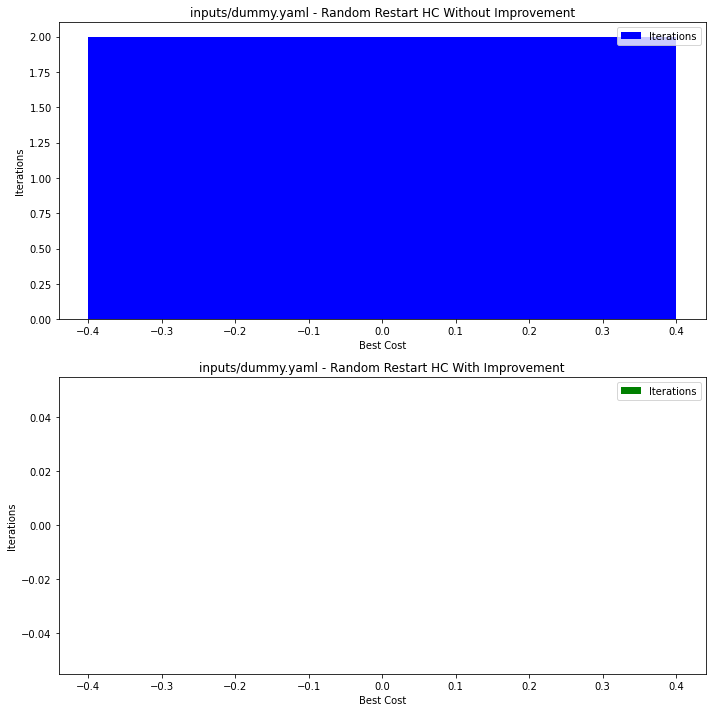

Random Restarts:   0%|          | 0/100 [01:29<?, ?it/s]


KeyboardInterrupt: 

In [581]:
# input_files = [
#     "inputs/dummy.yaml",
#     # "inputs/orar_bonus_exact.yaml",
#     "inputs/orar_constrans_incalcat.yaml",
#     "inputs/orar_mare_relaxat.yaml",
#     "inputs/orar_mediu_relaxat.yaml",
#     "inputs/orar_mic_exact.yaml",
# ]

# with contextlib.redirect_stdout(io.StringIO()):
#     for input_file in input_files:
#         plot_random_restart_hc(input_file)

# for file in input_files:
#     random_restart_hill_climbing(file)